# 📌 CLEAN_PIPELINE

**Author** : Thierry CAROLE <br>
**Date** : 22/04/2025

# 🧾Goals

The objectives of this challenge is to predict insurance premiums based on various factors.

https://www.kaggle.com/competitions/regression-with-an-insurance-dataset-bt-2-ds/overview

# Load libraries

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
import math
from scipy.stats import iqr
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor,Lasso,ElasticNet,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

from sklearn.metrics import make_scorer, mean_squared_log_error

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor, Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer


# 📁 Loading data

In [2]:
# Determining training data path
data_path = "../data/raw_data/train.csv"

# Check if the file exists
if os.path.exists(data_path):
    data = pd.read_csv(data_path)
    print("File loaded successfully.")
else:
    print(f"File not found: {data_path}")
    sys.exit()  # Exits the script here

File loaded successfully.


In [3]:
# Make a copy of the data
data_copy = data.copy()

In [4]:
# Overview of the first lines
data.head(2)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0


In [5]:
# Function to remove empty spaces in column names
def remove_empty_spaces_in_cols(df):
        """
    Removes empty spaces in column names
    Args:
        df (DataFrame): Raw data
    Returns:
        df (Dataframe) without empty spaces into column names
    """
        for col in df.columns:
            df.rename(columns = {col : col.replace(' ','_')},inplace=True)
        return df

In [6]:
def check_duplicates(df):
    """
    Counts duplicated rows. If any, function drops duplicated rows.
    Args:
        df (DataFrame): Raw data
    Returns:
        df (Dataframe) without duplicated rows
    """

    # Check number of rows before removing duplicates
    print(f"Number of rows : {len(df)}")

    # Compute the number of duplicated rows
    print(f"Number of duplicated rows : {df.duplicated().sum()}")

    if df.duplicated().sum()>0:
        # Remove duplicates
        df_no_duplicates = df.drop_duplicates()
        print("Duplicated rows have been removed")
        return df_no_duplicates
    else:
        print("No duplicated rows found !")
        return df  

In [7]:
def extract_year_month_day(df, column):
        """
        Removes empty spaces in column names
        Args:
            - df (DataFrame): Raw data
            - column (str) : column to convert to date time
        Returns:
            - df (Dataframe) with 3 additional columns from 'column' : year, month and day
            - column has been dropped
        """

        df[column] = pd.to_datetime(df[column])
        df[f"{column}_year"] = df[column].dt.year
        df[f"{column}_month"] = df[column].dt.month
        df[f"{column}_day"] = df[column].dt.day
        df.drop(columns=column, inplace=True)
        return df

In [8]:
# Function 
def show_missing_data(data):
    
        """
    Creates a dataframe listing the features and associated percentage of missing values.
    Args:
        - df (DataFrame): Raw data
    Returns:
        - New dataframe listing the features and associated percentage of missing values.
        - List of column names of features which have missing values
    """       
        
        # Counting the percentage of NaN for each column
        missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

        # missing_data
        missing_data = missing_data[missing_data > 0]

        #Missing data column names
        missing_cols = missing_data.index.values.tolist()

        #Show missing data in percent
        return missing_data, missing_cols

In [9]:
def create_pair_correlation_df(df):
        """
    Creates a dataframe listing pair correlations and absolute correlations
    Args:
        df (DataFrame): Raw data
    Returns:
        New df with pair correlations
    """
        num_df = df.select_dtypes(include='number')
    
        #Create a dataframe listing pair correlations and absolute correlations
        correlation_matrix = num_df.corr()

        # Converting the correlation matrix into a DataFrame
        corr_df = correlation_matrix.stack().reset_index()

        # Renaming the columns
        corr_df.columns = ['feature_1','feature_2', 'correlation']

        # Remove "self correlations"
        no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
        corr_df = corr_df[no_self_correlation]

        corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

        corr_df.sort_values(by="absolute_correlation", ascending=False, inplace = True)
        return corr_df

In [10]:
def create_target_feature_corr(df, target_name):
    """
    Creates a dataframe listing correlations between target feature and the other features
    Args:
        - df (DataFrame): Raw data
        - target name : string
    Returns:
        New df with correlations between target and the other features
    """
    corr_df = create_pair_correlation_df(df)
    corr_target_feat_df = corr_df[corr_df["feature_1"] == target_name].head(40)
    return corr_target_feat_df

In [11]:
def extract_cols_outliers(df):
        """
    Extract the columns with outliers.
    Args:
        df (DataFrame): Raw data
    Returns:
        - a list of numerical columns with outliers
        - a list of nnumerical columns without outliers
    """
        # Identify the columns with outliers
        numerical_columns_w_outliers = []
        numerical_columns_no_outliers = []
        
        num_df = df.select_dtypes(include='number')
        numerical_columns = num_df.columns
        
        for col in numerical_columns: 
            # Calculate IQR
            iqr_value = iqr(df[col],nan_policy='omit')
        
            #Calculate 1st quartile
            q1 = np.percentile(df[col],25)
        
            #Calculate 3rd quartile
            q3 = np.percentile(df[col],75)
        
            #Calculate lower limit below which data point is considered an outlier
            outlier_lim_low = q1 - 1.5 * iqr_value
        
            #Calculate higher limit above which data point is considered an outlier
            outlier_lim_high = q3 + 1.5 * iqr_value
            
            #Calculate number of 'low' outliers
            outlier_condition_low = df[col] < outlier_lim_low
            number_outliers_low = len(df[outlier_condition_low][col])
            
            #Calculate number of 'high' outliers
            outlier_condition_high = df[col] > outlier_lim_high
            number_outliers_high = len(df[outlier_condition_high][col])
            
            #Calculate total number of outliers
            number_outliers_total = number_outliers_low + number_outliers_high
            
            #If any outliers in column, column is added to a list of columns with outliers
            if number_outliers_total > 0:
                numerical_columns_w_outliers.append(col)
            elif number_outliers_total == 0:
                numerical_columns_no_outliers.append(col)

        return numerical_columns_w_outliers, numerical_columns_no_outliers

In [12]:
# remove empty spaces in column names
data = remove_empty_spaces_in_cols(data)

# Convert to datetime AND Extract year, month, day
data = extract_year_month_day(data, 'Policy_Start_Date')

# Let's delete the "id" column and columns with least correlation with target
data.drop(columns=['id','Insurance_Duration','Policy_Start_Date_day','Vehicle_Age','Number_of_Dependents'], inplace=True)

# Check of duplicated values within dataset
data = check_duplicates(data)

# Show Missing values in percentage
missing_perc_df, missing_cols = show_missing_data(data)
display(missing_perc_df)

#Create a dataframe listing correlations between a feature and the target and absolute correlations
target_name = 'Premium_Amount'
corr_target_feat_df = create_target_feature_corr(data, target_name)
display(corr_target_feat_df)

Number of rows : 1200000
Number of duplicated rows : 7
Duplicated rows have been removed


Previous_Claims      30.335594
Occupation           29.839507
Credit_Score         11.490234
Customer_Feedback     6.485288
Health_Score          6.173036
Annual_Income         3.745689
Age                   1.558759
Marital_Status        1.544092
dtype: float64

,feature_1,feature_2,correlation,absolute_correlation
43,Premium_Amount,Previous_Claims,0.046872,0.046872
44,Premium_Amount,Credit_Score,-0.026017,0.026017
42,Premium_Amount,Health_Score,0.014707,0.014707
41,Premium_Amount,Annual_Income,-0.012385,0.012385
46,Premium_Amount,Policy_Start_Date_year,-0.011087,0.011087
47,Premium_Amount,Policy_Start_Date_month,0.006706,0.006706
40,Premium_Amount,Age,-0.002431,0.002431


In [13]:
# Numerical columns
numerical_cols = ['Age','Annual_Income','Health_Score','Previous_Claims','Credit_Score','Policy_Start_Date_year','Policy_Start_Date_month']
# Categorical columns
categorical_cols= ['Gender','Marital_Status','Education_Level','Occupation','Location','Policy_Type','Customer_Feedback','Smoking_Status','Exercise_Frequency','Property_Type']
# Numerical columns in missing columns
numerical_missing_columns = ['Age', 'Annual_Income', 'Health_Score', 'Previous_Claims', 'Credit_Score']
# # Numerical columns
numerical_cols = ['Age','Annual_Income','Health_Score','Previous_Claims','Credit_Score','Policy_Start_Date_year','Policy_Start_Date_month']


# # Categorical columns
categorical_cols= ['Gender','Marital_Status','Education_Level','Occupation','Location','Policy_Type','Customer_Feedback','Smoking_Status','Exercise_Frequency','Property_Type']
# Numerical columns that are not in missing columns
numerical_NOT_missing_columns = ['Policy_Start_Date_year', 'Policy_Start_Date_month']


# Categorical columns that are in missing columns
categorical_missing_columns = ['Marital_Status', 'Occupation', 'Customer_Feedback']
# Categorical columns that are not in missing columns
categorical_NOT_missing_columns = ['Gender', 'Education_Level','Location', 'Policy_Type', 'Smoking_Status', 'Exercise_Frequency', 'Property_Type']


numerical_columns_w_outliers = []
numerical_columns_no_outliers= ['Age', 'Annual_Income', 'Health_Score', 'Previous_Claims', 'Credit_Score', 'Policy_Start_Date_year', 'Policy_Start_Date_month']
# # Numerical columns imputed WITH outliers (Robust scaling)
numerical_missing_columns_with_outliers=[]
# # Numerical columns imputed WITHOUT outliers (MinMax scaling)
numerical_missing_columns_without_outliers=['Age', 'Annual_Income', 'Health_Score', 'Previous_Claims', 'Credit_Score']
# Numerical columns NOT imputed WITH outliers (Robust scaling)
numerical_NOT_missing_columns_with_outliers = []
# Numerical columns NOT imputed WITHOUT outliers (MinMax scaling)
numerical_NOT_missing_columns_without_outliers= ['Policy_Start_Date_year', 'Policy_Start_Date_month']

# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['Gender', 'Marital_Status', 'Occupation','Location','Smoking_Status','Exercise_Frequency','Property_Type']
categorical_columns_ohe_missing=['Marital_Status', 'Occupation']
categorical_columns_ohe_NOT_missing=['Gender', 'Location', 'Smoking_Status', 'Exercise_Frequency', 'Property_Type']

# Create pipeline for numerical columns and categorical columns
num_transformer_imputer_robust = make_pipeline(SimpleImputer(strategy='median'), RobustScaler())
num_transformer_imputer_minmax = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler())
num_transformer_NO_imputer_robust = make_pipeline(RobustScaler())
num_transformer_NO_imputer_minmax = make_pipeline(MinMaxScaler())

cat_transformer_imputer_ohe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False,drop = 'if_binary'))
cat_transformer_NO_imputer_ohe = make_pipeline(OneHotEncoder(sparse_output=False,drop = 'if_binary'))

# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['Policy_Type', 'Education_Level','Customer_Feedback']

categorical_columns_imputer_ordinal=['Customer_Feedback']
categorical_columns_NO_imputer_ordinal = ['Policy_Type', 'Education_Level']


# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

Policy_Type_cat=['Basic','Comprehensive','Premium']
Education_Level_cat=['High School', "Bachelor's","Master's",'PhD' ]
Customer_Feedback_cat=['Poor','Average','Good']

ordered_categories_imputer_ordinal = [Customer_Feedback_cat]
ordered_categories_NO_imputer_ordinal = [Policy_Type_cat, Education_Level_cat]

cat_transformer_imputer_ordinal = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories = ordered_categories_imputer_ordinal))
cat_transformer_NO_imputer_ordinal = make_pipeline(OrdinalEncoder(categories = ordered_categories_NO_imputer_ordinal))

print(data.shape)

# Create column transformer
preproc_basic = make_column_transformer(
    # (num_transformer_imputer_robust, numerical_missing_columns_with_outliers),
    (num_transformer_imputer_minmax, numerical_missing_columns_without_outliers),
    (num_transformer_NO_imputer_robust, numerical_NOT_missing_columns_with_outliers),
    (num_transformer_NO_imputer_minmax, numerical_NOT_missing_columns_without_outliers),
    (cat_transformer_imputer_ohe, categorical_columns_ohe_missing),
    (cat_transformer_NO_imputer_ohe, categorical_columns_ohe_NOT_missing),
    (cat_transformer_imputer_ordinal, categorical_columns_imputer_ordinal),
    (cat_transformer_NO_imputer_ordinal, categorical_columns_NO_imputer_ordinal),   
    remainder='passthrough'
)

(1199993, 18)


In [14]:
final_model = make_pipeline(preproc_basic, LGBMRegressor())
final_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Annual_Income',
                                                   'Health_Score',
                                                   'Previous_Claims',
                                                   'Credit_Score']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  []),
                                                 (...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Poor',
                                                                                               'Average',
                                                                                               'Good']]))]),
                                                  ['Customer_Feedback']),
                                                 ('pipeline-7',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Basic',
                                                                                               'Comprehensive',
                                                                                               'Premium'],
                                                                                              ['High '
                                                                                               'School',
                                                                                               "Bachelor's",
                                                                                               "Master's",
                                                                                               'PhD']]))]),
                                                  ['Policy_Type',
                                                   'Education_Level'])])),
                ('lgbmregressor', LGBMRegressor())])

# 🧠 Modeling / Machine Learning

## Features and target

In [15]:
# Define X and y
target_name = 'Premium_Amount'
X = data.drop(columns= target_name)
y = data[target_name]

In [16]:
# Separating train set from test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display shapes
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of X_train : (839995, 17)
Shape of X_test : (359998, 17)
Shape of y_train : (839995,)
Shape of y_test : (359998,)


## Metric

In [17]:
def root_mean_squared_log_error(y_test, y_pred):
        """
    Calcuates the root mean squared logarithmic error between real target values and predicted target values
    Args:
        - y_test: real target values
        - y_pred: predicted target values
    Returns:
        Root mean squared logarithmic error
    """
        return np.sqrt(mean_squared_log_error(y_test, y_pred))

# Wrapper to use in cros_val_score function (I want the root mean squared log error to be as small as possible)
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

## Cross validation

In [18]:
# %%time

# # Selection of models to try out (BE CAREFUL : 1h46min to cross validate !!!)
# # linear_models = [LinearRegression(), 
# #                  Ridge(random_state=42),
# #                  Lasso(random_state=42),
# #                  RandomForestRegressor(random_state=42),
# #                  GradientBoostingRegressor(random_state=42),
# #                  SGDRegressor(random_state=42), 
# #                  XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42),
# #                  LGBMRegressor(random_state=42),
# #                  ElasticNet(random_state=42)]

# linear_models = [LinearRegression(),
#                  LGBMRegressor(random_state=42),
#                  Ridge(random_state=42),
#                  Lasso(random_state=42),
#                  ElasticNet(random_state=42)]

# rmsle_scores = {}

# # Train and evaluate the models
# for model in linear_models:
#     final_model = make_pipeline(preproc_basic, model)
#     rmsle = -cross_val_score(final_model, X_train, y_train, cv=5, scoring= rmsle_scorer).mean()
#     rmsle_scores[str(model)[:str(model).find('(')]] = rmsle
#     print(f"{model} is finished!")

# # Formatting the results into a dataframe
# rmsle_scores_df = pd.DataFrame(rmsle_scores, index=[0])
# rmsle_scores_df = rmsle_scores_df.T\
#                                 .reset_index()\
#                                 .rename(columns={0:'Mean_score', 'index' : 'Model'})\
#                                 .sort_values('Mean_score', ascending=True)
# display(rmsle_scores_df)

# print("*****************************")
# print(f"The best model from cross validation (in regard to scoring method) seems to be : {rmsle_scores_df.Model.head(1).values[0]}")
# print("*****************************")

## Prediction without fine tuning

In [19]:
# Fit model
model = LGBMRegressor()
final_model = make_pipeline(preproc_basic, model)
fitted_model = final_model.fit(X_train, y_train)

# Predictions
y_pred = fitted_model.predict(X_train)

# Metric
root_mean_squared_log_error(y_train, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 839995, number of used features: 28
[LightGBM] [Info] Start training from score 1102.831376


np.float64(1.1415707318544144)

## Fine tuning

In [20]:
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import RandomizedSearchCV

# Define the model
model = LGBMRegressor()
final_model = make_pipeline(preproc_basic, model)

# Define the parameter grid
param_dist = {
    'lgbmregressor__num_leaves': [20, 31, 50, 70],
    'lgbmregressor__max_depth': [-1, 5, 10, 15],
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'lgbmregressor__n_estimators': [100, 200, 500],
    'lgbmregressor__subsample': [0.6, 0.8, 1.0],
    'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'lgbmregressor__reg_alpha': [0, 0.01, 0.1],
    'lgbmregressor__reg_lambda': [0, 0.01, 0.1]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=final_model,
    param_distributions=param_dist,
    n_iter=5,          # How many random combinations to try
    scoring=rmsle_scorer,  # Good metric for regression
    cv=5,               # 5-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1           # Use all CPU cores
)

# Fit the search
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best model
best_model = random_search.best_estimator_
display(best_model)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/thierry/.pyenv/versions/regression_insurance_p

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.307382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 671996, number of used features: 28
[LightGBM] [Info] Start training from score 1103.387721


/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.382415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 671996, number of used features: 28
[LightGBM] [Info] Start training from score 1102.813160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.386213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 671996, number of used features: 28
[LightGBM] [Info] Start training from score 1101.886609


/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/thierry/.pyenv/versions/regression_insurance_premium/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/thierry/.pyenv/versions/regression_insurance_p

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 839995, number of used features: 28
[LightGBM] [Info] Start training from score 1102.831376
Best Parameters: {'lgbmregressor__subsample': 0.8, 'lgbmregressor__reg_lambda': 0.1, 'lgbmregressor__reg_alpha': 0, 'lgbmregressor__num_leaves': 31, 'lgbmregressor__n_estimators': 200, 'lgbmregressor__max_depth': 10, 'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__colsample_bytree': 0.8}


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Annual_Income',
                                                   'Health_Score',
                                                   'Previous_Claims',
                                                   'Credit_Score']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  []),
                                                 (...
                                                  ['Customer_Feedback']),
                                                 ('pipeline-7',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Basic',
                                                                                               'Comprehensive',
                                                                                               'Premium'],
                                                                                              ['High '
                                                                                               'School',
                                                                                               "Bachelor's",
                                                                                               "Master's",
                                                                                               'PhD']]))]),
                                                  ['Policy_Type',
                                                   'Education_Level'])])),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05,
                               max_depth=10, n_estimators=200, reg_alpha=0,
                               reg_lambda=0.1, subsample=0.8))])

## Prediction after fine tuning

In [23]:
# Fit model
best_fitted_model = best_model.fit(X_train, y_train)

# Predictions
y_pred = best_fitted_model.predict(X_train)

# Metric
root_mean_squared_log_error(y_train, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 839995, number of used features: 28
[LightGBM] [Info] Start training from score 1102.831376


np.float64(1.143722869439919)

# 📊 Results analysis / visualization

In [24]:
# # Train
# final_model = make_pipeline(preproc_basic, LGBMRegressor())
# final_model.fit(X, y)

In [25]:
# columns = final_model.named_steps.columntransformer.get_feature_names_out().tolist()

# # Get feature importance (the model's coefficients)
# # Plot
# plt.figure(figsize=(10,6))
# plt.barh(columns, final_model.named_steps.lgbmregressor.feature_importances_)
# plt.xlabel('Feature Importance (Coefficient Value)')
# plt.title(f'Feature Importance')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [26]:
# Train
best_fitted_model = best_model.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 1199993, number of used features: 28
[LightGBM] [Info] Start training from score 1102.546807


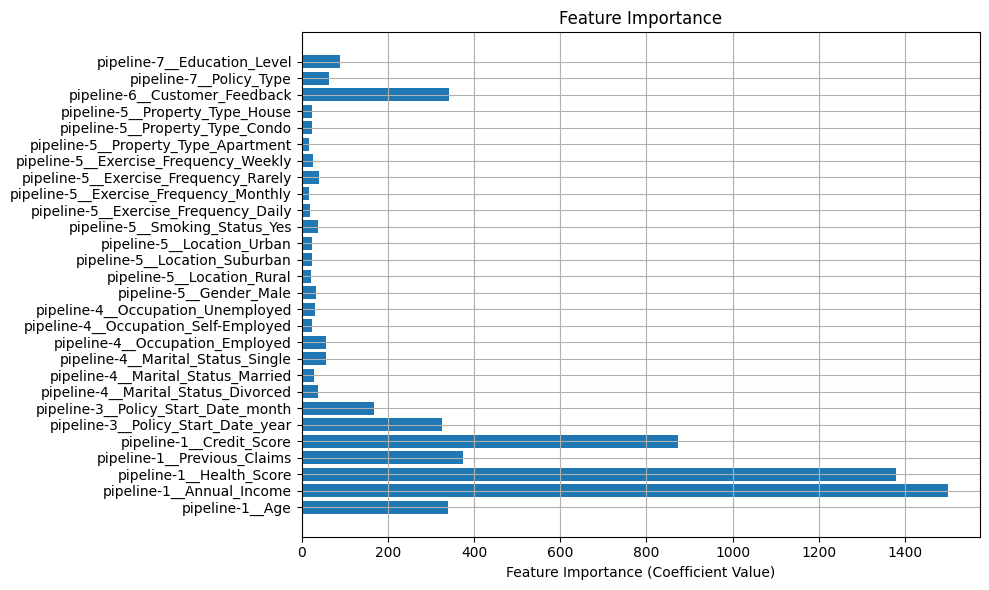

In [27]:
columns = best_fitted_model.named_steps.columntransformer.get_feature_names_out().tolist()

# Get feature importance (the model's coefficients)
# Plot
plt.figure(figsize=(10,6))
plt.barh(columns, best_fitted_model.named_steps.lgbmregressor.feature_importances_)
plt.xlabel('Feature Importance (Coefficient Value)')
plt.title(f'Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧪Conclusion and recommendations

## Fitting model on entire test data

In [28]:
# # Let's fit the model on the whole data
# final_model = make_pipeline(preproc_basic, LGBMRegressor())
# fitted_model = final_model.fit(X, y)

In [29]:
# Let's fit the model on the whole data
best_fitted_model = best_model.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 1199993, number of used features: 28
[LightGBM] [Info] Start training from score 1102.546807


## Prepare test data

In [30]:
# Determining test data path
data_path = "../data/raw_data/test.csv"

# Check if the file exists
if os.path.exists(data_path):
    test_data = pd.read_csv(data_path)
    print("File loaded successfully.")
else:
    print(f"File not found: {data_path}")
    sys.exit()  # Exits the script here

File loaded successfully.


In [31]:
test_data_copy = test_data.copy()

In [32]:
# Overview of the first lines
display(test_data.shape)
test_data.head(2)

(800000, 20)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment


In [33]:
# Determining test data path
data_path = "../data/raw_data/sample_submission.csv"

# Check if the file exists
if os.path.exists(data_path):
    sample_submission = pd.read_csv(data_path)
    print("File loaded successfully.")
else:
    print(f"File not found: {data_path}")
    sys.exit()  # Exits the script here

File loaded successfully.


In [34]:
# Overview of the first lines
sample_submission.head(2)

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545


## Prediction of test data

### Preprocess Test data

In [35]:
# remove empty spaces in column names
test_data = remove_empty_spaces_in_cols(test_data)

# Convert to datetime AND Extract year, month, day
test_data = extract_year_month_day(test_data, 'Policy_Start_Date')

# Let's delete the "id" column and columns with least correlation with target
test_data.drop(columns=['id','Insurance_Duration','Policy_Start_Date_day','Vehicle_Age','Number_of_Dependents'], inplace=True)

# display(f"Before : {test_data.shape}")
# # Check of duplicated values within dataset
# test_data = check_duplicates(test_data)
# display(f"After : {test_data.shape}")

# # Show Missing values in percentage
# missing_perc_df, missing_cols = show_missing_data(test_data)
# display(missing_perc_df)

### Predict test_data

In [36]:
# Predictions
y_pred_test = best_fitted_model.predict(test_data)
y_pred_test = np.round(y_pred_test, 3)
y_pred_test

array([1431.156, 1111.451, 1090.817, ..., 1118.653, 1129.702, 1051.915],
      shape=(800000,))

In [37]:
submission = pd.DataFrame(y_pred_test, columns=['Premium Amount'])
submission['id'] = test_data_copy['id']
submission = submission[['id','Premium Amount']]
submission.head()

,id,Premium Amount
0,1200000,1431.156
1,1200001,1111.451
2,1200002,1090.817
3,1200003,1090.835
4,1200004,1029.600


### Record submission file locally 

In [38]:
# Generate filename
filename = "submission.csv"
now = datetime.now()
dated_filename = now.strftime("%Y%m%d_%H-%M-%S_"+filename)
saving_path = "../data/processed_data/" + dated_filename
submission.to_csv(saving_path, index=False, sep=',', encoding='utf-8')

# 📦 Appendices / references